# Two-pool model from Barker *et al.* (2020)

In [1]:
pwd()

"/home/kkganko/6.337/18.337-Project-SP2023/Stochastic Diffeqs"

In [2]:
dir_contents = readdir(".")

14-element Vector{String}:
 ".ipynb_checkpoints"
 "Birth-Death.ipynb"
 "BirthDeathFlux.ipynb"
 "Fitting Data to SDE Practice.ipynb"
 "Lux Tutorial.ipynb"
 "MWE Birth-Death-KG.ipynb"
 "MWE Birth-Death.ipynb"
 "MWE Two-Pool-KG.ipynb"
 "Manifest.toml"
 "NN_sde_combined.png"
 "Neural ODE Practice.ipynb"
 "Neural SDE Practice.ipynb"
 "Project.toml"
 "Stochastic Diffeq Practice.ipynb"

In [3]:
dir_contents_parent = readdir("..")

12-element Vector{String}:
 ".git"
 ".gitignore"
 ".ipynb_checkpoints"
 "LICENSE"
 "Manifest.toml"
 "Min working example.ipynb"
 "Project.toml"
 "README.md"
 "Stochastic Diffeqs"
 "generate-project-toml.ipynb"
 "test_lux-componentarrays.ipynb"
 "test_python.ipynb"

In [4]:
# # If Project.toml and Manifest.toml exist, remove them to start a completely fresh installation of packages and dependencies.
# # This is equivalent to uninstalling all packages in the current environment. 
# # Why? B/c if you don't start from a clean plate, and you have previous package dependency installation that were unspecified 
# # below in their version number, then dependencies may conflict.

# # get contents of working directory
# dir_contents = readdir(".")
# println(dir_contents)
# if "Manifest.toml" in dir_contents
#     rm("Manifest.toml")
#     println("Removed Manifest.toml from $(pwd()).")
# end
# if "Project.toml" in dir_contents
#     rm("Project.toml")
#     println("Removed Project.toml from $(pwd()).")
# end

# # Check file contents in project directory, copy over Project.toml and Manifest.toml if they exist.
# # If they don't exist, create them with generate-project-toml.ipynb.
# parentdir_contents = readdir("..")
# parentdir_info = stat("..")
# # copy contents from parent to working directory 
# if "Manifest.toml" in parentdir_contents
#     cp("../Manifest.toml", joinpath(pwd(),"Manifest.toml"))
#     println("Manifest.toml copy from project dir to $(pwd()) successful.")
# else
#     println("No Manifest.toml in parent directory.")
# end
# if "Project.toml" in parentdir_contents
#     cp("../Project.toml", joinpath(pwd(),"Project.toml"))
#     println("Project.toml copy from project dir to $(pwd()) successful.")
# else
#     println("No Project.toml in parent directory.")
# end

In [5]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

  Activating project at `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs`


In [6]:
Pkg.status()

      Status `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [b0b7db55] ComponentArrays v0.13.12
  [8f4d0f93] Conda v1.8.0
  [aae7a2af] DiffEqFlux v1.54.0
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.91
  [587475ba] Flux v0.13.16
  [f6369f11] ForwardDiff v0.10.35
  [bd48cda9] GraphRecipes v0.5.12
  [86223c79] Graphs v1.8.0
  [7073ff75] IJulia v1.24.0
  [4138dd39] JLD v0.13.3
  [b964fa9f] LaTeXStrings v1.3.0
  [b2108857] Lux v0.4.53
  [429524aa] Optim v1.7.5
  [7f7a1694] Optimization v3.14.1
  [253f991c] OptimizationFlux v0.1.4
  [91a5bcdd] Plots v1.38.11
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [731186ca] RecursiveArrayTools v2.38.3
  [1ed8b502] SciMLSensitivity v7.31.0
  [e88e6eb3] Zygote v0.6.61


In [7]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using DifferentialEquations.StochasticDiffEq
using DifferentialEquations.DiffEqCallbacks
using DifferentialEquations.DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using DifferentialEquations.DiffEqBase.EnsembleAnalysis
using BenchmarkTools
using LaTeXStrings
using Printf # print formatting
using ForwardDiff
using Graphs
using GraphRecipes
using RecursiveArrayTools
using Lux

# Define SDE model: Change to Non-mutating form to aid Zygote in backprop!

See for recommendations: https://discourse.julialang.org/t/zygote-and-sde-failure-cannot-differentiate-through-lux-nn/84177.

In [8]:
# set up problem: initial conditions, params, solver hyperparams
datasize = 201
tspan = (0.0, 10.0)
tsteps = range(tspan[1], tspan[2], length = datasize)
NOISE_STRUCT = zeros(Float64,2,4)

2×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [9]:
# new implementation that can handle Dual numbers for autodiff, i.e., with ForwardDiff.Dual
# some algs tested below require this functionality: ImplicitEulerHeun especially
# also added Lux.Tracker.TrackedReal for du, u, and Lux.Tracker.TrackedArray for params (which comes as matrices in NNs)
# function trueSDEfunc!(
#         du::Vector{T1},
#         u::Vector{T2},
#         p::Vector{T3},
#         t::Float64
# ) where {
#     T1<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T2<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T3<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedArray}
#     }
function trueSDEfunc!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1] = R4-R1-R3
        du[2] = R3-R2-R4
    end
end

# # non-mutating version
# function trueSDEfunc(u,p,t)
#     @inbounds begin
#         # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
#         R1 = exp(p[1])*u[1]
#         R2 = exp(p[2])*u[2]
#         R3 = exp(p[3])*u[1]
#         R4 = exp(p[4])*u[2]
#         du1 = R4-R1-R3
#         du2 = R3-R2-R4
#         return [du1,du2]
#     end
# end

# new implementation that can't handle Dual numbers for autodiff...
# also added Lux.Tracker.TrackedReal for du, u, and Lux.Tracker.TrackedArray for params (which comes as matrices in NNs)
# function true_noise_func!(
#         du::Matrix{T1},
#         u::Vector{T2},
#         p::Vector{T3},
#         t::Float64
# ) where {
#     T1<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T2<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedReal},
#     T3<:Union{ForwardDiff.Dual,Float64,Lux.Tracker.TrackedArray}
#     }
function true_noise_func!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1, 1] = -sqrt(R1)
        du[1, 3] = -sqrt(R3)
        du[1, 4] = sqrt(R4)
        du[2, 2] = -sqrt(R2)
        du[2, 3] = sqrt(R3)
        du[2, 4] = -sqrt(R4)
    end
end

# # non-mutating version
# function true_noise_func(u,p,t)
#     @inbounds begin
#         # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
#         R1 = exp(p[1])*u[1]
#         R2 = exp(p[2])*u[2]
#         R3 = exp(p[3])*u[1]
#         R4 = exp(p[4])*u[2]
#         du = NOISE_STRUCT
#         du[1, 1] = -sqrt(R1)
#         du[1, 3] = -sqrt(R3)
#         du[1, 4] = sqrt(R4)
#         du[2, 2] = -sqrt(R2)
#         du[2, 3] = sqrt(R3)
#         du[2, 4] = -sqrt(R4)
#         return du
#     end
# end

# callbacks
# terminate_condition(u,t,integrator) = (u[1] < 0.0) || (u[2] < 0.0)
# affect_solver!(integrator) = terminate!(integrator, ReturnCode.Terminated) # can't use symbols for retcodes anymore, need to reference directly from ReturnCode object
# cb_stop_solver = DiscreteCallback(terminate_condition,affect_solver!)
# cbs = CallbackSet(cb_stop_solver)

# reflecting condition, helps stabilize ensemble results
# see https://stackoverflow.com/questions/69049991/simulating-a-reflecting-boundary-sdeproblem
function affect!(integrator)
    if integrator.u[2] < 0
        integrator.u[2] = -integrator.u[2]
    end
end

condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,true))
cbs = CallbackSet(cb_reflect)

u_0 = Float64[
    100.0,
    0.0
]
p_true = log.(Float64[
    0.1,
    0.2,
    0.2,
    0.5
])

# put an integer-valued seed to reproduce behavior
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs,
    seed=1
)

# # Non-mutating version is ~6x longer
# prob_truesde_nonmutating = SDEProblem(
#     trueSDEfunc,
#     true_noise_func,
#     u_0,
#     tspan,
#     p_true,
#     noise_rate_prototype = NOISE_STRUCT,
#     callback=cbs,
#     seed=1
# )


println("New implementation EM:")
b1 = @benchmark sol1 = solve(prob_truesde, EM(), dt = 0.05, save_everystep=false)
display(b1)

println("LambaEM w/ guess on initial dt:")
b3 = @benchmark sol3 = solve(prob_truesde, LambaEM(), dt=0.05, save_everystep=false)
display(b3)

New implementation EM:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  59.000 μs …  37.690 ms  ┊ GC (min … max): 0.00% … 96.52%
 Time  (median):     66.700 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   75.107 μs ± 379.404 μs  ┊ GC (mean ± σ):  4.84% ±  0.97%

   ▅█▄▃▅▅▆▃▁                                                    
  ▆█████████▆▅▄▄▃▃▃▂▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  59 μs           Histogram: frequency by time          128 μs <

 Memory estimate: 34.97 KiB, allocs estimate: 271.

LambaEM w/ guess on initial dt:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  70.200 μs …  50.139 ms  ┊ GC (min … max): 0.00% … 99.79%
 Time  (median):     81.000 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   94.156 μs ± 501.095 μs  ┊ GC (mean ± σ):  5.31% ±  1.00%

   ▁▂▁▅█▇▃                                                      
  ▅███████▇▅▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  70.2 μs         Histogram: frequency by time          172 μs <

 Memory estimate: 19.53 KiB, allocs estimate: 209.

In [10]:
# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# ground truth for two-pool model using ensemble of 100000 trajectories
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# # hellishly long
# prob_truesde_nonmutating = SDEProblem(
#     trueSDEfunc,
#     true_noise_func,
#     u_0,
#     tspan,
#     p_true,
#     noise_rate_prototype = NOISE_STRUCT,
#     callback=cbs
# )

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N, save_everystep=false)

EnsembleSolution Solution of length 100000 with uType:
RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(trueSDEfunc!), typeof(true_noise_func!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(true_noise_func!), Base.Pairs{Symbol, CallbackSet{Tuple{}, 

In [11]:
# parse to remove failed simulations
parsed_sol = [(sol.u[i].retcode != ReturnCode.Success ? nothing : sol.u[i]) for i in 1:length(sol.u)]
parsed_sol = parsed_sol[parsed_sol.!=nothing]
truemean = mean(parsed_sol)[:,:]
truevar = var(parsed_sol)[:, :];

# number/proportion of failed simulations
println("$(N-length(parsed_sol)) failed simulations, or $(1-length(parsed_sol)/N)")

0 failed simulations, or 0.0


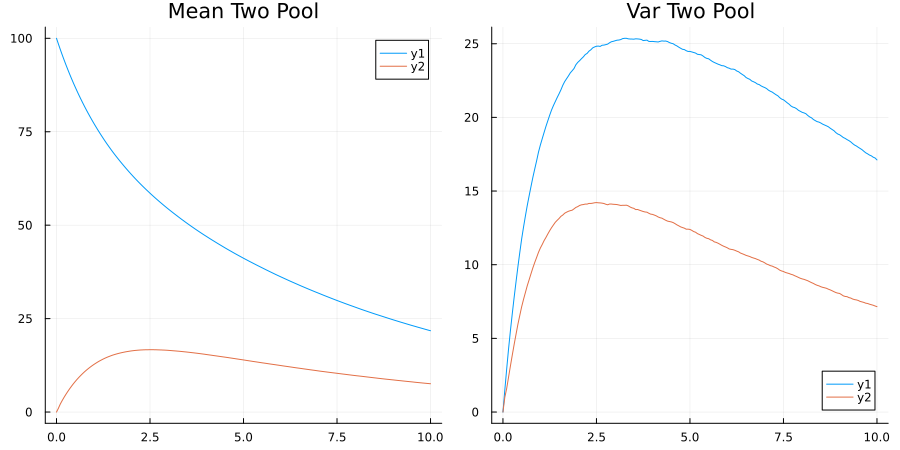

In [12]:
# plot ground truth
p_twopool_mean = plot(sol.u[1].t,truemean',title = "Mean Two Pool")
p_twopool_var = plot(sol.u[1].t,truevar', title = "Var Two Pool")

plot(
    p_twopool_mean,
    p_twopool_var,
    layout = (1,2),
    size = (900,450)
)

# Define NNs for Reaction Fluxes and Forward Simulate with SDE

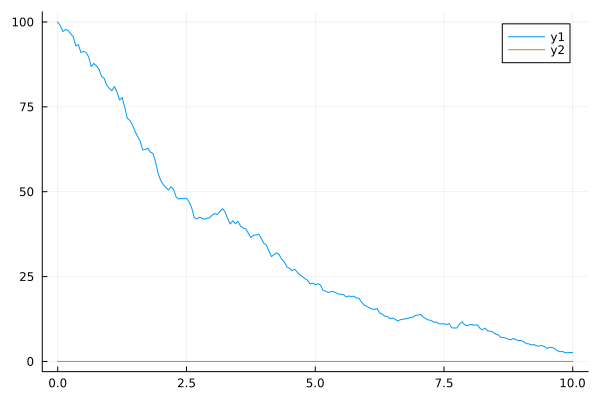

In [13]:
# NN: R^2 -> R^4, relu on final layer to force positive outputs
# ratesmodel = FastChain(FastDense(2 , 16, relu), FastDense(16 , 4, relu));
# p_nn = initial_params(ratesmodel);

# using Lux necessitates you to explicitly pass the states, `st`, into model run
# also note that two-pool model deals with partial observability of the system, so input is R^1, output still R^4
ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, relu));
p_nn, st = Lux.setup(Xoshiro(0), ratesmodel)

# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# # Old functions for Flux.jl
# function ratestodrift(u, p, t)
#     R1,R2,R3,R4 = ratesmodel(u,p,st)
#     return [
#         R4-(R1+R3),
#         R3-(R2+R4)
#     ]
# end

# function ratestodiff(u, p, t)
#     R1_r,R2_r,R3_r,R4_r = sqrt.(ratesmodel(u,p,st))
#     return [
#         R1_r 0.0 -R3_r R4_r;
#         0.0 R2_r R3_r R4_r
#     ]
# end

# updating rates from NNs function to deal with Lux framework better
# need to explicitly pass the states, and also need to extract the output at the first index (second index is NamedTuple)
# pass only partial state information, i.e., u[1] in two pool model
function ratestodrift(u, p, t)
    R1,R2,R3,R4 = ratesmodel(u,rebuild(p),st)[1]
    return [
        (R4*(u[2]>0)-(R1+R3)*(u[1]>0)),
        (R3*(u[1]>0)-(R2+R4)*(u[2]>0))
    ]
end

function ratestodiff(u, p, t)
    R1_r,R2_r,R3_r,R4_r = ratesmodel(u,rebuild(p),st)[1].^(1/2)
    return [
        R1_r*(u[1]>0) 0.0 -R3_r*(u[1]>0) R4_r*(u[2]>0);
        0.0 R2_r*(u[2]>0) R3_r*(u[1]>0) R4_r*(u[2]>0)
    ]
end

# change callback saving to cut down on timepoints being saved
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(p_nn)[1],
    noise_rate_prototype = NOISE_STRUCT,
#     callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')

In [14]:
# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# test zygote
# computing Jacobian instead of gradient (since output is multivariate)
# need to index to 1st element... since NamedTuple for structure of NN is 2nd element
# input to zygote must be flattened, input to ratesmodel must be rebuilt
# index zygote output to first index since zygote output is 1-tuple
res = Zygote.jacobian(p->ratesmodel(u_0,rebuild(p),st)[1],Flux.destructure(p_nn)[1])[1]

4×116 Matrix{Float64}:
 0.0  0.0  26.0569  44.9218   49.6919   …  0.0   0.0     1.0  0.0  0.0  0.0
 0.0  0.0  17.0491  30.8621   11.265       0.0   0.0     0.0  1.0  0.0  0.0
 0.0  0.0   0.0      0.0       0.0         0.0   0.0     0.0  0.0  0.0  0.0
 0.0  0.0  30.0881   6.06655   7.56537     0.0  55.0411  0.0  0.0  0.0  1.0

In [15]:
# p_nn_cat = []
# # println(fieldnames(typeof(p_nn)))
# # println(fieldnames(typeof(p_nn.layer_1)))
# for i in fieldnames(typeof(p_nn))
#     println(i)
#     for j in fieldnames(typeof(p_nn[i]))
#         println(p_nn[Symbol(i)][Symbol(j)])
#         p_nn_cat = vcat(p_nn_cat,vec(p_nn[Symbol(i)][Symbol(j)]))
#     end
# end
# # power (?) of named tuples
# # p_nn[:layer_1][:weight]
# p_nn_cat

# Backprop with Neural SDE

1. Cannot use callbacks since `setindex!` cannot be differentiated. :(
2. DO NOT USE `EnsembleProblem()` W/ ANY CODE MEANT TO BE AD'ed! IT WILL CRASH THE DAMN KERNEL!
3. `TrackerAdjoint()` as a sensealg is not working. Even on single SDE solve, it produces a gradient that is just bad with a whole lot of `NaN`s. Looking at documentation on sensitivity algs (https://docs.sciml.ai/SciMLSensitivity/stable/manual/differential_equation_sensitivities/#SciMLSensitivity.ReverseDiffAdjoint), it seems like Zygote-based and Tracker-based AD methods are simply overstated. `ForwardDiffSensitivity()` should work just fine, albeit it is very slowwwwwwww, and may even cause mismatch with the fact that we are calling a `Zygote.gradient` reverse-mode computed gradient when `ForwardDiffSensitivity()` is doing forward-mode AD to get the sensitivities.

In [77]:
function loss_neuralsde1(p,u=u_0,n=100)
    dt = 0.05
    tstops = length(range(tspan[1], step=dt, stop=tspan[2]))
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT)#, callback=cbs)
    res = map(
        (x->solve(prob, EM(), dt = dt, saveat = dt; save_everystep=false, sensealg=ForwardDiffSensitivity())),
        [u_0 for i in 1:n]
    )

    VA = VectorOfArray(res)
    arr = convert(Array,VA)
    means = mean(arr, dims = 3)
    vars = var(arr, dims = 3, mean = means)
    loss = sum(abs2, truemean .- means) + sum(abs2, truevar .- vars) + 1.0 * sum(abs2, p) + 1.0 * sum(abs, p) # elastic net without hyperparameters optimized
    
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=100
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
test_loss = loss_neuralsde1(flat)
# res = Zygote.gradient(p->loss_neuralsde(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde1(p,u_0,n),flat)

116-element Vector{Float64}:
      -2.019341230392456
      -1.103372484445572
  180261.97201454456
  310767.3141876216
  343767.0382758607
  -29721.644620475457
      -1.8944538831710815
 -117280.05989341345
      -1.2045346945524216
      -2.0862321853637695
  111077.4624247193
   55738.242343901635
      -1.6305271983146667
       ⋮
       1.8454792499542236
      -2.006476640701294
      -1.7279481291770935
       1.5751716494560242
  380313.57974146924
       1.446482092142105
      -1.227069929242134
       1.0001026415702654
   16992.26487652084
       1.0
       1.0
       1.0

# Simulate on full observability case (measuring both states)

In [ ]:
# the ForwardDiff version of this optimization
# https://docs.sciml.ai/Optimization/stable/API/optimization_function/#Optimization.AutoForwardDiff
opt = ADAM(0.001)
losses = []
params_list = []
MAX_ITERS = 500 # around 36 seconds/iter on KKG comp, so ~5hrs for 500 iters

# save progress of solution, https://docs.sciml.ai/Optimization/stable/API/solve/#CommonSolve.solve-Tuple{OptimizationProblem,%20Any}
function callback(params,loss_val)
    
    # record round number and 
    println("Round $(length(params_list)) training loss: $(loss_val)")
    push!(losses,loss_val)
    push!(params_list,params)
    length(params_list) >= MAX_ITERS
end

# First round of training with n = 10
t1 = time_ns()
adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde1(x), adtype)
optprob = Optimization.OptimizationProblem(optf, flat)
result1 = Optimization.solve(optprob, opt, maxiters = MAX_ITERS, callback=callback);
t2 = time_ns()
println("Total time elapsed: $((t2-t1)/1.0e9) seconds")

In [87]:
loss_neuralsde1(flat)

173470.40554657154

In [85]:
loss_neuralsde1(result1.u)

164035.35921509413

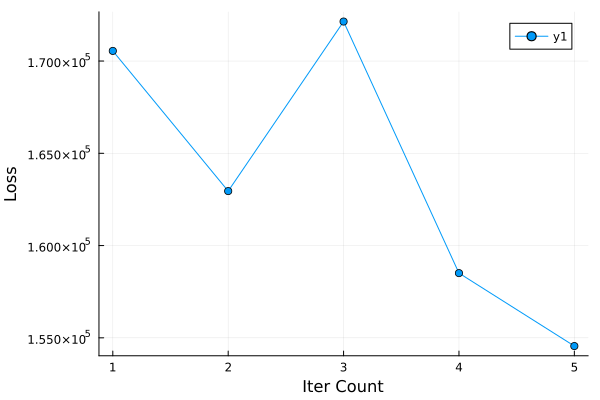

In [86]:
plot(1:MAX_ITERS,losses,ylabel = "Loss", xlabel = "Iter Count", markershape=:circle)

# Simulate on partial observability case (measuring only first state)

WIP